# Laboratory Work №4

Лабораторная работа посвящена задаче детекции и классификации кибербуллинга в текстах из соц. сети Twitter с применением метаэвристики (алгоритма оптимизации) и комбинированной нейросетевой модели

## SETUP

In [ ]:
!pip install emoji -q
!pip install contractions -q
!pip install mealpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.1 MB/s eta 0:00:00


In [ ]:
# @title Imports {display-mode: "form"}

import pandas as pd
from tqdm import tqdm
from google.colab import drive
import re
import emoji
from collections import Counter
from html import unescape
import contractions
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, f1_score
from keras.optimizers import Adam
from mealpy.swarm_based.SSO import OriginalSSO
from mealpy import Problem, StringVar, IntegerVar, MixedSetVar
import torch
import pickle

In [ ]:
# @title Env Preparation {display-mode: "form"}

pd.options.mode.chained_assignment = None
tqdm.pandas(colour='black')
!python -m spacy download en_core_web_md -q

nlp = spacy.load("en_core_web_md")
nlp.disable_pipes('ner', 'parser')
nlp.add_pipe('sentencizer')
stop_words = nlp.Defaults.stop_words
print(nlp.pipe_names)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'sentencizer']


## DATASET

In [ ]:
# @title GDrive {display-mode: "form"}

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/data/cyberbullying/cyberbullying_tweets.csv', index_col='Unnamed: 0').rename(
    {'tweet_text': 'text',
     'cyberbullying_type': 'label'}, axis=1)
df

,text,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
52419,Fuck red &amp; white dumb ugly nigger name Way...,ethnicity
52420,Bitch u mad........ I see!!!! RT @tayyoung_: F...,gender
52421,"8.5/10 first of all, i love your profile pictu...",not_cyberbullying
52422,@Dustin___Lee when you find him let me know so...,not_cyberbullying


## EDA

### Overview

Убедимся в отсутствии пустых строк

In [ ]:
df.replace('', pd.NA, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52424 entries, 0 to 52423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    52424 non-null  object
 1   label   52424 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
df.describe()

,text,label
count,52424,52424
unique,52424,6
top,"In other words #katandandre, your food was cra...",not_cyberbullying
freq,1,13034


Наблюдения:
* 6 классов
* Все тексты в датасете уникальны
* Самый большой класс — not_cyberbullying с >13_000 текстами

In [ ]:
df.sample(10, random_state=42)

,text,label
15506,"It’s amazing that this guy can show up, tell p...",gender
37238,I didn’t even know what call her daddy was bef...,age
212,"Old school, Degrassi&gt;&gt;&gt;&gt;&gt; #That...",not_cyberbullying
11210,RT @GeorgeN101: Call me sexist but holding a c...,gender
48432,The rosti looks like one massive chip that has...,not_cyberbullying
1165,RT @ZoutLiquorice: For dessert we're making de...,not_cyberbullying
4962,"@rsanc vem logo, tou sendo gongada por estar e...",not_cyberbullying
21492,@CamilleHughes16 @_Watch_Observe_ I don't real...,religion
49507,@Dabiq_Warrior The moron Baghdadi thinks he ca...,not_cyberbullying
30876,girls who bullied me in high school are huffle...,age


Из выведенных примеров видим, что тексты содержат много лишнего по типу тегов пользователей, хэштегов, HTML-тегов и проч.

Посмотрим на баланс классов в датасете

In [ ]:
df['label'].value_counts()

not_cyberbullying      13034
gender                  8810
religion                8330
age                     7993
ethnicity               7967
other_cyberbullying     6290
Name: label, dtype: int64

Поскольку датасет был составлен нами из двух датасетов, посвящённых кибербуллингу в Твиттере, изначальный баланс классов был нарушен. Для начала предобработаем датасет, а затем посмотрим, нужно ли нам будет работать с несбалансированными данными.

### Anomaly Long Texts

array([[<Axes: title={'center': 'tokenized_text_len'}>]], dtype=object)

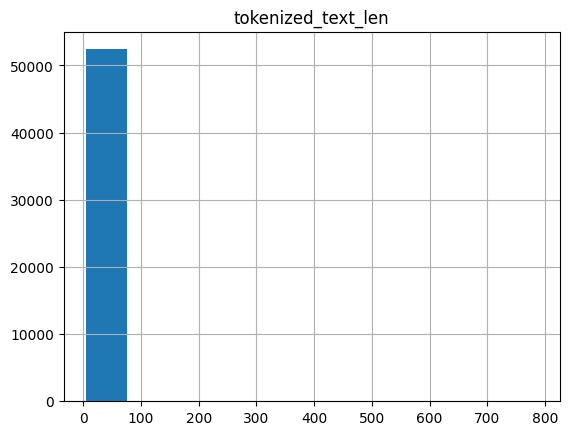

In [ ]:
df['tokenized_text_len'] = df['text'].apply(lambda x: len(x.split()))
df.hist(column='tokenized_text_len', rwidth=0.9)

На графике видно, что большинство текстов содержат до 100 токенов, но в датасете также присутствуют и слишком длинные тексты. Это одна из проблем оригинального датасета: какие-то тексты при парсинге были обработаны неправильно, из-за чего некоторые ячейки, фактически, содержат сразу несколько текстов под одним лейблом. При объединении датасетов мы не стали удалять эти ячейки, поскольку их обработка уже входила в нашу первую работу. Тем не менее, мы разобрали эти склеенные тексты и добавили их по-отдельности, разметив вручную.

К примеру, вот часть самого длинного текста в датасете.

In [ ]:
longest_text = max(df['text'], key=len)
print(f'''Longest text: "{longest_text[:500]}...",
Symbols count:{len(longest_text)},
Words count: {len(longest_text.split())}''')

Longest text: "is feminazi an actual word with a denot…
@Nasharchy my job means protecting people. even the people i don't agree with/like.
They barely cooked anything on that entrée #MKR
RT @kf: Like, no. If a community fostering jerks prevents users from adopting that community's code, it is very much a technical problem.
It's almost time. :)
@JamesGweenwood shock youre bullying me again.
@LionLionEatEat yeah, someone DMed me a screenshot. meh. let her. i have no idea who she even is.
For more egregio...",
Symbols count:5018,
Words count: 790


А так выглядит самый короткий текст. Понимаем, что датасет содержит эмодзи

In [ ]:
shortest_text = min(df['text'], key=len)
print(f'''Shortest text: "{shortest_text}",
Symbols count:{len(shortest_text)},
Words count: {len(shortest_text.split())}''')

Shortest text: "💩",
Symbols count:1,
Words count: 1


## PREPROCESSING

### Anomaly Long Texts

Для начала избавимся от аномальных текстов

Для этого мы не устанавливаем максимальную допустимую длину текста, а пользуемся следующим наблюдением:

In [ ]:
longest_text[:100]

'is feminazi an actual word with a denot…\r\n@Nasharchy my job means protecting people. even the people'

In [ ]:
df['text'][0]

'In other words #katandandre, your food was crapilicious! #mkr'

Склеенные тексты содержат сочетание символов *\r\n* между частями, в то время как нормальные этого сочетания символов не содержат

In [ ]:
df = df.loc[df['text'].str.contains("\r\n")==False]
df = df.reset_index(drop=True)
df.shape

(52401, 3)

Таким образом мы дропнули чуть больше 20-и строк.

In [ ]:
longest_text = max(df['text'], key=len)
print(f'''Longest text: "{longest_text}",
Symbols count:{len(longest_text)},
Words count: {len(longest_text.split())}''')

Longest text: "(2/2) The MO State Constitution (Art. VI sec 18(c)) prohibits charter counties from exercising any power over the school functions. Will the school boards and school superintendents in St. Louis County stand up to Page the bully? https://www.stltoday.com/news/local/metro/page-says-more-restrictions-in-st-louis-county-possible-if-coronavirus-cases-continue-to-grow/article_c11b1fb1-7f78-56ac-98d8-07cbfb7bbb39.html#utm_source=stltoday.com&amp;utm_campaign=%2Fnewsletter-templates%2Fpolitical-fix&amp;utm_medium=PostUp&amp;utm_content=5bd8b4b585b0024e0c7fb4d8f9ec3274bc64a6fe",
Symbols count:575,
Words count: 38


Как видим, от склеенных текстов мы избавились

### Hashtags

Исследуем хэштеги отдельно, чтобы понять, заменять их на плейсхолдеры или оставить без изменений.

In [ ]:
df_with_tags = df.loc[df['text'].str.contains(r'#\w+')]
df_with_tags.shape

(10054, 3)

In [ ]:
df_with_tags['label'].value_counts()

not_cyberbullying      5220
gender                 2097
religion                884
other_cyberbullying     785
ethnicity               668
age                     400
Name: label, dtype: int64

Хэштеги содержатся в ≈1/5 части датасета, при этом они встречаются во всех классах, поэтому, вероятно, заменять их одним плейсхолдером — не лучшая идея.
Посмотрим на них поближе

In [ ]:
tag_counter = Counter()
for row in df_with_tags.iterrows():
  tag_counter.update(re.findall(r'#\w+', row[1]['text']))

len(list(tag_counter))

5548

Посмотрим на несколько наиболее и наименее частотных хэштегов

In [ ]:
tag_counter.most_common(10)

[('#MKR', 2691),
 ('#mkr', 2380),
 ('#Islam', 193),
 ('#mkr2015', 161),
 ('#MKR2015', 159),
 ('#ISIS', 156),
 ('#notsexist', 138),
 ('#BlameOneNotAll', 117),
 ('#NotSexist', 77),
 ('#coon', 75)]

In [ ]:
tag_counter.most_common()[:-11:-1]

[('#INCORPORATED', 1),
 ('#HUNTING', 1),
 ('#NKC', 1),
 ('#fuckgays', 1),
 ('#TrumpTrain', 1),
 ('#128049', 1),
 ('#StopWhitePeople2014', 1),
 ('#babys', 1),
 ('#pork', 1),
 ('#attacks', 1)]

Видим разнообразные хэштеги, при этом отметим, что у нас есть вариации в написании самого частотного тега. Посмотрим, к какому классу в датасете они относятся

In [ ]:
df_with_tags.loc[df_with_tags['text'].str.contains('#MKR')]['label'].value_counts()

not_cyberbullying      2132
gender                  470
other_cyberbullying     106
religion                  3
ethnicity                 2
Name: label, dtype: int64

In [ ]:
df_with_tags.loc[df_with_tags['text'].str.contains('#mkr')]['label'].value_counts()

not_cyberbullying      1922
gender                  445
other_cyberbullying      46
Name: label, dtype: int64

In [ ]:
df_with_tags.loc[df_with_tags['text'].str.contains('#MKR2015')]['label'].value_counts()

not_cyberbullying      108
gender                  39
other_cyberbullying     12
Name: label, dtype: int64

In [ ]:
df_with_tags.loc[df_with_tags['text'].str.contains('#mkr2015')]['label'].value_counts()

not_cyberbullying    125
gender                36
Name: label, dtype: int64

Поближе взглянув на хэштеги, в итоге пришли к решению не заменять их на плейсхолдеры.

Также мы решили заменить даты в хэштегах, поскольку, судя по рассмотренному нами примеру, наличие даты не сильно влияет на лейбл текста. Кроме того, это также позволит сократить размер словаря.

### Normalization pt. 1

Первым делом удалим не ASCII-символы, сократим излишние повторения и приведём HTML-коды в нормальный вид

In [ ]:
def remove_non_ascii(text: str) -> str:
  return re.sub(r'[^\x00-\x7f]', ' ', text)

def replace_repetitions(text: str) -> str:
  return re.sub(r"(.)\1{2,}", r"\1\1", text)

In [ ]:
df['filtered_text'] = df['text'].apply(remove_non_ascii).apply(unescape).apply(replace_repetitions)

### Placeholders

В  нашей оригинальной работе мы заменяли многие вещи в текстах на плейсхолдеры, однако сейчас в дополнение к этому мы проверим важность плейсхолдеров для классификации текстов и решим, какие из них нам стоит оставить, а какие стоит убрать.

Вот что мы заменяем на плейсхолдеры:

*   Теги пользователей (@User_Tag1 → USER_TAG_PLACEHOLDER);
*   Ссылки (http://...; https://...; pic.twitter.com/... → LINK_PLACEHOLDER);
*   Эмодзи (:); &#128514; :•) → EMOTE_PLACEHOLDER);
*   Даты (2000s → YEAR_PLACEHOLDER);
*   Числа (11; 1/3 → DIGITS_PLACEHOLDER).

In [ ]:
def replace_mentions(text: str) -> str:
  return re.sub(r"@\w*", 'USER_TAG_PLACEHOLDER', text)

def replace_urls(text: str) -> str:
  # sourced: https://urlregex.com/
  return re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", 'LINK_PLACEHOLDER', text)

def replace_emotes(text: str) -> str:
  text = re.sub(r"((?::|;|=)(?:-)?(?:\)|D|P|O|\\|/|\())", 'EMOTE_PLACEHOLDER', text)
  text = emoji.demojize(text)
  return text

def replace_dates(text: str) -> str:
  return re.sub(r"\d{4}s?", 'DATE_PLACEHOLDER', text)

def replace_numerals(text: str) -> str:
  return re.sub(r"\b\d[\d\.,/]*(st|th|rd|nd)?\b", 'NUMERAL_PLACEHOLDER', text)

def replace_pics(text: str) -> str:
  return re.sub(r'pic\.twitter\.com/\S+', 'PIC_PLACEHOLDER', text)

In [ ]:
df['filtered_text'] = df['filtered_text'] \
    .apply(replace_mentions) \
    .apply(replace_urls) \
    .apply(replace_pics) \
    .apply(replace_emotes) \
    .apply(replace_dates) \
    .apply(replace_numerals)

In [ ]:
def count_distribution(placeholder: str):
  labels = df['label'].unique()
  for label in labels:
    print(f"Доля текстов с плейсхолдером в классе {label.upper()} - {round(len(df.loc[(df['filtered_text'].str.contains(placeholder)) & (df['label'] == label)]) / len(df.loc[df['label'] == label]), 2)}")

Теги пользователей

In [ ]:
len(df.loc[df['filtered_text'].str.contains('USER_TAG_PLACEHOLDER')])

21013

In [ ]:
count_distribution('USER_TAG_PLACEHOLDER')

Доля текстов с плейсхолдером в классе NOT_CYBERBULLYING - 0.55
Доля текстов с плейсхолдером в классе GENDER - 0.44
Доля текстов с плейсхолдером в классе RELIGION - 0.3
Доля текстов с плейсхолдером в классе OTHER_CYBERBULLYING - 0.6
Доля текстов с плейсхолдером в классе AGE - 0.05
Доля текстов с плейсхолдером в классе ETHNICITY - 0.42


Ссылки

In [ ]:
len(df.loc[df['filtered_text'].str.contains('LINK_PLACEHOLDER')])

5179

In [ ]:
count_distribution('LINK_PLACEHOLDER')

Доля текстов с плейсхолдером в классе NOT_CYBERBULLYING - 0.16
Доля текстов с плейсхолдером в классе GENDER - 0.1
Доля текстов с плейсхолдером в классе RELIGION - 0.07
Доля текстов с плейсхолдером в классе OTHER_CYBERBULLYING - 0.17
Доля текстов с плейсхолдером в классе AGE - 0.02
Доля текстов с плейсхолдером в классе ETHNICITY - 0.04


Эмотиконы

In [ ]:
len(df.loc[df['filtered_text'].str.contains('EMOTE_PLACEHOLDER')])

1301

In [ ]:
count_distribution('EMOTE_PLACEHOLDER')

Доля текстов с плейсхолдером в классе NOT_CYBERBULLYING - 0.04
Доля текстов с плейсхолдером в классе GENDER - 0.01
Доля текстов с плейсхолдером в классе RELIGION - 0.0
Доля текстов с плейсхолдером в классе OTHER_CYBERBULLYING - 0.07
Доля текстов с плейсхолдером в классе AGE - 0.01
Доля текстов с плейсхолдером в классе ETHNICITY - 0.01


Даты

In [ ]:
len(df.loc[df['filtered_text'].str.contains('DATE_PLACEHOLDER')])

1165

In [ ]:
count_distribution('DATE_PLACEHOLDER')

Доля текстов с плейсхолдером в классе NOT_CYBERBULLYING - 0.03
Доля текстов с плейсхолдером в классе GENDER - 0.02
Доля текстов с плейсхолдером в классе RELIGION - 0.03
Доля текстов с плейсхолдером в классе OTHER_CYBERBULLYING - 0.01
Доля текстов с плейсхолдером в классе AGE - 0.02
Доля текстов с плейсхолдером в классе ETHNICITY - 0.02


Числа

In [ ]:
len(df.loc[df['filtered_text'].str.contains('NUMERAL_PLACEHOLDER')])

5213

In [ ]:
count_distribution('NUMERAL_PLACEHOLDER')

Доля текстов с плейсхолдером в классе NOT_CYBERBULLYING - 0.08
Доля текстов с плейсхолдером в классе GENDER - 0.07
Доля текстов с плейсхолдером в классе RELIGION - 0.14
Доля текстов с плейсхолдером в классе OTHER_CYBERBULLYING - 0.07
Доля текстов с плейсхолдером в классе AGE - 0.14
Доля текстов с плейсхолдером в классе ETHNICITY - 0.1


Картинки

In [ ]:
len(df.loc[df['filtered_text'].str.contains('PIC_PLACEHOLDER')])

148

In [ ]:
count_distribution('PIC_PLACEHOLDER')

Доля текстов с плейсхолдером в классе NOT_CYBERBULLYING - 0.0
Доля текстов с плейсхолдером в классе GENDER - 0.0
Доля текстов с плейсхолдером в классе RELIGION - 0.0
Доля текстов с плейсхолдером в классе OTHER_CYBERBULLYING - 0.0
Доля текстов с плейсхолдером в классе AGE - 0.0
Доля текстов с плейсхолдером в классе ETHNICITY - 0.02


Ознакомившись с распределением плейсхолдеров по классам, мы пришли к выводу, что они не дают значимой информации, поскольку равномерно распределены между всеми классами. Кроме того, некоторые плейсхолдеры встречаются слишком редко.

### Normalization pt. 2

Здесь мы приведём сокращённые слова к нормальной форме, удалим плейсхолдеры, лемматизируем текст и приведём его к нижнему регистру, а также оставим в текстах только слова, полностью состоящие из букв латинского алфавита, поскольку мы подразумеваем работу только с английскими текстами

In [ ]:
def fix_contractions(text: str) -> str:
  return contractions.fix(text)

def lemmatize(text: str) -> str:
  return " ".join([token.lemma_ for token in nlp(text) if token.lemma_ not in stop_words])

def lowercase(text: str) -> str:
  return text.lower()

def remove_placeholders(text: str) -> str:
  placeholders = ('USER_TAG_PLACEHOLDER', 'LINK_PLACEHOLDER', 'EMOTE_PLACEHOLDER', 'DATE_PLACEHOLDER', 'NUMERAL_PLACEHOLDER', 'PIC_PLACEHOLDER')
  for placeholder in placeholders:
    text = re.sub(placeholder, '', text)
  return text

def clear_text(text: str) -> str:
  return ' '.join(re.findall(r'\b[a-z]+\b', text))

In [ ]:
df['filtered_text'] = df['filtered_text'] \
  .apply(remove_placeholders) \
  .apply(fix_contractions) \
  .progress_apply(lemmatize) \
  .apply(lowercase) \
  .apply(clear_text)

100%|██████████| 52401/52401 [05:40<00:00, 153.98it/s]


In [ ]:
df.sample(5, random_state=42)

,text,label,tokenized_text_len,filtered_text
25829,#WWYD if You saw the kids who bullied MB?,other_cyberbullying,9,wwyd kid bully mb
35906,In what incident did you thought Acai is the o...,age,47,incident think acai i high school i average gi...
45027,Fuck you lame Niggers! Y'all not Trill! Wanna ...,ethnicity,21,fuck lame niggers trill want know cuz ya dumb ...
33981,When the girls who bullied me in middle/high s...,age,35,girl bully i middle high school like girl post...
48133,Ass cream?? #mkr #mkr2015,not_cyberbullying,4,ass cream mkr mkr


In [ ]:
df['filtered_text'].duplicated().sum()

2223

In [ ]:
df['filtered_text'].replace('', pd.NA).isna().sum()

529

После предобработки у нас появились дубликаты и пустые строки. Удалим их.

In [ ]:
df = df.drop_duplicates('filtered_text').replace('', pd.NA).dropna().reset_index(drop=True)
df

,text,label,tokenized_text_len,filtered_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,9,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,14,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,9,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,18,meh thank head concerned angry dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,18,isis account pretend kurdish account like isla...
...,...,...,...,...
50172,I love everyone who screams about reverse raci...,ethnicity,47,i love scream reverse racism like i m shame wh...
50173,Bitch u mad........ I see!!!! RT @tayyoung_: F...,gender,12,bitch mad i rt fuck obama dumb ass nigger
50174,"8.5/10 first of all, i love your profile pictu...",not_cyberbullying,45,i love profile picture sander fandom super coo...
50175,@Dustin___Lee when you find him let me know so...,not_cyberbullying,14,find let i know i hunt coon


Проверим итоговый баланс классов

In [ ]:
df['label'].value_counts()

not_cyberbullying      12192
gender                  8417
religion                8253
age                     7861
ethnicity               7697
other_cyberbullying     5757
Name: label, dtype: int64

Наблюдаем дисбаланс.

In [ ]:
df.to_csv('drive/MyDrive/data/cyberbullying/preprocessed_df.csv', mode='x')

## CHECKPOINT

In [ ]:
# @title GDrive {display-mode: "form"}

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_preprocessed = pd.read_csv('drive/MyDrive/data/cyberbullying/preprocessed_df.csv', index_col='Unnamed: 0').drop(columns=['text', 'tokenized_text_len'])
df_preprocessed

,label,filtered_text
0,not_cyberbullying,word katandandre food crapilicious mkr
1,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,not_cyberbullying,classy whore red velvet cupcake
3,not_cyberbullying,meh thank head concerned angry dude twitter
4,not_cyberbullying,isis account pretend kurdish account like isla...
...,...,...
50172,ethnicity,i love scream reverse racism like i m shame wh...
50173,gender,bitch mad i rt fuck obama dumb ass nigger
50174,not_cyberbullying,i love profile picture sander fandom super coo...
50175,not_cyberbullying,find let i know i hunt coon


## VOCAB PREPARATION

Создадим векторы одной длины. Для этого посмотрим на распределение длин текстов.

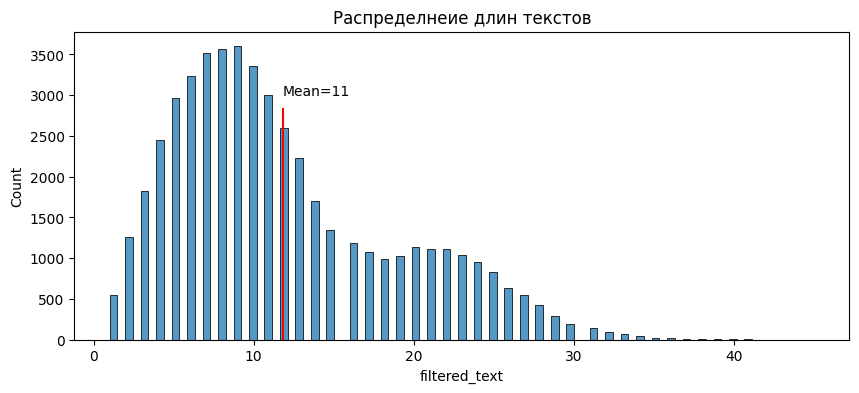

In [ ]:
text_lengths = df_preprocessed['filtered_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 4))
sns.histplot(text_lengths)
plt.title('Распределнеие длин текстов')
plt.axvline(x=np.mean(text_lengths), ymin=0, ymax=0.75, color='r')
plt.text(np.mean(text_lengths), 3000, f'Mean={int(np.mean(text_lengths))}')
plt.show()

Средняя длина текстов — 11 токенов. Будем использовать её для стандартного обучения.

Также посмотрим на количество уникальных токенов в наших текстах

In [ ]:
BOW = []

for text in df_preprocessed['filtered_text']:
  BOW.extend(text.split())

token_counter = Counter(BOW)
len(token_counter)

36354

In [ ]:
def create_vocab(token_counter: Counter, min_count: int):
  vocab = []
  for token, n in token_counter.most_common():
    if n == min_count:
      break
    vocab.append(token)
  return vocab

vocab = create_vocab(token_counter, 0)
len(vocab)

36354

Также создадим общую функцию, которая будет использоваться для предобработки текстов. Это пригодится при деплоинге и инференсе модели

In [ ]:
def preprocess(text: str) -> str:
  text = re.sub(r'[^\x00-\x7f]', ' ', text) # remove non_ascii
  text = unescape(text)
  text = re.sub(r"(.)\1{2,}", r"\1\1", text) #remove repetitions
  text = re.sub(r"@\w*", '', text) # remove user tags
  text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", '', text) # remove links
  # remove emojis
  text = re.sub(r"((?::|;|=)(?:-)?(?:\)|D|P|O|\\|/|\())", '', text)
  text = emoji.demojize(text)
  text = re.sub(r"\d{4}s?", '', text) # remove dates
  text = re.sub(r"\b\d[\d\.,/]*(st|th|rd|nd)?\b", '', text) # remove numerals
  text = re.sub(r'pic\.twitter\.com/\S+', '', text) # remove pic links
  text = contractions.fix(text) # fix contractions
  text = " ".join([token.lemma_ for token in nlp(text) if token.lemma_ not in stop_words]) # lemmatize
  text = text.lower() # lowercase
  text = ' '.join(re.findall(r'\b[a-z]+\b', text)) # leave only eng text
  return text

## SPLIT DATA

Закодируем лейблы

In [ ]:
labels, uniques = pd.factorize(df_preprocessed['label'], size_hint=6)
labels_map = {}
for i, unique in enumerate(uniques):
  labels_map[i] = unique

df_preprocessed['label'] = labels
df_preprocessed

,label,filtered_text
0,0,word katandandre food crapilicious mkr
1,0,aussietv white mkr theblock imacelebrityau tod...
2,0,classy whore red velvet cupcake
3,0,meh thank head concerned angry dude twitter
4,0,isis account pretend kurdish account like isla...
...,...,...
50172,5,i love scream reverse racism like i m shame wh...
50173,1,bitch mad i rt fuck obama dumb ass nigger
50174,0,i love profile picture sander fandom super coo...
50175,0,find let i know i hunt coon


In [ ]:
labels_map

{0: 'not_cyberbullying',
 1: 'gender',
 2: 'religion',
 3: 'other_cyberbullying',
 4: 'age',
 5: 'ethnicity'}

Разделим датасет

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_preprocessed['filtered_text'], df_preprocessed['label'], test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(40141,) (10036,) (40141,) (10036,)


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

## EXPERIMENTS

In [ ]:
callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

### Standard Models

Сначала прогоним эксперименты на отобранных нами моделях. Всего для нашей задачи мы отобрали 6 моделей, 4 из которых — доработанные модели из первых двух лабораторных, показавшие лучшие результаты на тех задачах.

Если говорить об оставшихся двух, то  

*   одна собрана по описанию архитектуры из статьи, посвящённой работе с оригинальным датасетом, расширенная версия которого использована в нашей работе
*   другая модель была сгенерирована специализированной LLM после предоставления исчерпывающих данных о задаче, датасете и имеющихся в нашем распоряжении векторов

In [ ]:
class StandardModel:
  def __init__(self, vocab: list, vectors_len: int):
    self._vocab = vocab
    self._vec_len = vectors_len

  def create_model(self, model_type: str):
    available_models = ('full_con_s', 'full_con_k', 'crnn_s', 'crnn_k', 'cnn_p', 'nnnn')
    if model_type not in available_models:
        raise KeyError(f'No such model. Available models are: {available_models}')

    model = None
    if model_type == 'full_con_s':
      model = self._create_model_S1()
    elif model_type == 'full_con_k':
      model = self._create_model_K1()
    elif model_type == 'crnn_s':
      model = self._create_model_S2()
    elif model_type == 'crnn_k':
      model = self._create_model_K2()
    elif model_type == 'cnn_p':
      model = self._create_model_cbp()
    elif model_type == 'nnnn':
      model = self._create_model_n4()
    if model is not None:
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

  def _create_model_S1(self):
    model =Sequential([
        TextVectorization(
          max_tokens=len(self._vocab) + 2,
          standardize=None,
          vocabulary=self._vocab,
          split='whitespace',
          output_mode='int',
          output_sequence_length=self._vec_len
          ),
        Embedding(input_dim=len(self._vocab) + 2, output_dim=128, input_length=self._vec_len),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(.5),
        Dense(32, activation='relu'),
        Dropout(.3),
        Dense(6, activation='softmax')
    ])
    return model

  def _create_model_K1(self):
    model = Sequential([
        TextVectorization(
          max_tokens=len(self._vocab) + 2,
          standardize=None,
          vocabulary=self._vocab,
          split='whitespace',
          output_mode='int',
          output_sequence_length=self._vec_len
          ),
        Embedding(input_dim=len(self._vocab) + 2, output_dim=40, input_length=self._vec_len),
        Flatten(),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dropout(.2),
        Dense(6, activation='softmax')
    ])
    return model

  def _create_model_S2(self):
    model = Sequential()
    model.add(TextVectorization(
        max_tokens=len(self._vocab) + 2,
        standardize=None,
        vocabulary=self._vocab,
        split='whitespace',
        output_mode='int',
        output_sequence_length=self._vec_len
        )
    )
    model.add(Embedding(input_dim=len(self._vocab) + 2, output_dim=100, input_length=self._vec_len))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D())
    model.add(GRU(100, dropout=0.5))
    model.add(Dense(6, activation='softmax'))
    return model

  def _create_model_K2(self):
    model = Sequential()
    model.add(TextVectorization(
        max_tokens=len(self._vocab) + 2,
        standardize=None,
        vocabulary=self._vocab,
        split='whitespace',
        output_mode='int',
        output_sequence_length=self._vec_len
        )
    )
    model.add(Embedding(input_dim=len(self._vocab) + 2, output_dim=12, input_length=self._vec_len))
    model.add(GRU(32, return_sequences=True))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))
    return model

  def _create_model_cbp(self):
    model = Sequential([
        TextVectorization(
          max_tokens=len(self._vocab) + 2,
          standardize=None,
          vocabulary=self._vocab,
          split='whitespace',
          output_mode='int',
          output_sequence_length=self._vec_len
          ),
        Embedding(input_dim=len(self._vocab) + 2, output_dim=100, input_length=self._vec_len),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(10, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

  def _create_model_n4(self):
    model = Sequential([
    TextVectorization(
        max_tokens=len(self._vocab) + 2,
        standardize=None,
        vocabulary=self._vocab,
        split='whitespace',
        output_mode='int',
        output_sequence_length=self._vec_len
        ),
    Embedding(input_dim=len(self._vocab) + 2, output_dim=128, input_length=self._vec_len),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax')
    ])
    return model

In [ ]:
model_creator = StandardModel(vocab, 11)

#### Model 1

Fully connected model, Slava's implementation from lab1

In [ ]:
model_full_con_s = model_creator.create_model('full_con_s')

In [ ]:
with tf.device('/gpu:0'):
  history_full_con_s = model_full_con_s.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

Epoch 1/15
502/502 [==============================] - 32s 61ms/step - loss: 1.7176 - accuracy: 0.2914 - val_loss: 1.4873 - val_accuracy: 0.5676
Epoch 2/15
502/502 [==============================] - 26s 51ms/step - loss: 1.2132 - accuracy: 0.5792 - val_loss: 0.9222 - val_accuracy: 0.6813
Epoch 3/15
502/502 [==============================] - 22s 43ms/step - loss: 0.8580 - accuracy: 0.6846 - val_loss: 0.7215 - val_accuracy: 0.7255
Epoch 4/15
502/502 [==============================] - 19s 38ms/step - loss: 0.7181 - accuracy: 0.7281 - val_loss: 0.6603 - val_accuracy: 0.7458
Epoch 5/15
502/502 [==============================] - 21s 42ms/step - loss: 0.6349 - accuracy: 0.7603 - val_loss: 0.6327 - val_accuracy: 0.7546
Epoch 6/15
502/502 [==============================] - 23s 46ms/step - loss: 0.5735 - accuracy: 0.7878 - val_loss: 0.6172 - val_accuracy: 0.7621
Epoch 7/15
502/502 [==============================] - 21s 41ms/step - loss: 0.5211 - accuracy: 0.8119 - val_loss: 0.6092 - val_accuracy:

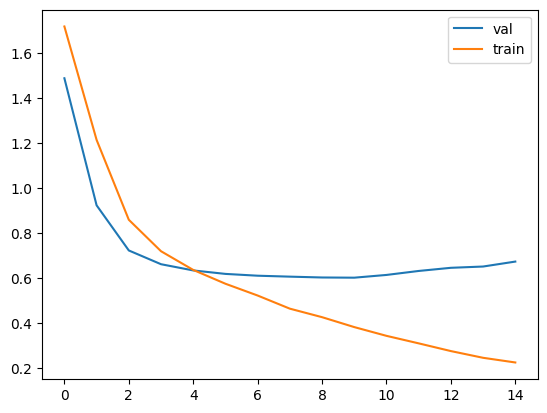

In [ ]:
plt.plot(history_full_con_s.history['val_loss'], label='val')
plt.plot(history_full_con_s.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_full_con_s.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 11s 35ms/step
              precision    recall  f1-score   support

           0       0.74      0.58      0.65      2503
           1       0.82      0.80      0.81      1632
           2       0.87      0.90      0.89      1652
           3       0.46      0.68      0.55      1161
           4       0.89      0.92      0.90      1607
           5       0.91      0.88      0.89      1481

    accuracy                           0.78     10036
   macro avg       0.78      0.79      0.78     10036
weighted avg       0.79      0.78      0.78     10036



In [ ]:
model_full_con_s.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Tex  (None, 11)                0         
 tVectorization)                                                 
                                                                 
 embedding_10 (Embedding)    (None, 11, 128)           4653568   
                                                                 
 flatten_6 (Flatten)         (None, 1408)              0         
                                                                 
 dense_21 (Dense)            (None, 64)                90176     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                     

#### Model 2

Fully connected model, Karina's implementation from lab1

In [ ]:
model_full_con_k = model_creator.create_model('full_con_k')

In [ ]:
with tf.device('/gpu:0'):
  history_full_con_k = model_full_con_k.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

Epoch 1/15
502/502 [==============================] - 40s 73ms/step - loss: 1.7457 - accuracy: 0.2848 - val_loss: 1.6482 - val_accuracy: 0.4803
Epoch 2/15
502/502 [==============================] - 23s 46ms/step - loss: 1.4465 - accuracy: 0.5091 - val_loss: 1.1963 - val_accuracy: 0.6372
Epoch 3/15
502/502 [==============================] - 25s 50ms/step - loss: 1.0676 - accuracy: 0.6183 - val_loss: 0.9206 - val_accuracy: 0.7059
Epoch 4/15
502/502 [==============================] - 23s 45ms/step - loss: 0.8849 - accuracy: 0.6740 - val_loss: 0.8014 - val_accuracy: 0.7218
Epoch 5/15
502/502 [==============================] - 26s 51ms/step - loss: 0.7758 - accuracy: 0.7081 - val_loss: 0.7390 - val_accuracy: 0.7315
Epoch 6/15
502/502 [==============================] - 21s 41ms/step - loss: 0.7004 - accuracy: 0.7398 - val_loss: 0.6986 - val_accuracy: 0.7418
Epoch 7/15
502/502 [==============================] - 20s 40ms/step - loss: 0.6458 - accuracy: 0.7596 - val_loss: 0.6777 - val_accuracy:

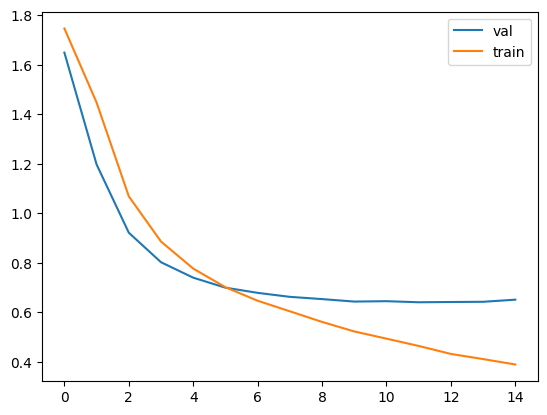

In [ ]:
plt.plot(history_full_con_k.history['val_loss'], label='val')
plt.plot(history_full_con_k.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_full_con_k.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 11s 34ms/step
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      2503
           1       0.81      0.78      0.79      1632
           2       0.84      0.90      0.87      1652
           3       0.49      0.64      0.55      1161
           4       0.89      0.90      0.89      1607
           5       0.90      0.87      0.88      1481

    accuracy                           0.77     10036
   macro avg       0.77      0.78      0.77     10036
weighted avg       0.78      0.77      0.77     10036



In [ ]:
model_full_con_k.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 11)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 11, 40)            1454240   
                                                                 
 flatten_1 (Flatten)         (None, 440)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                8820      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                      

#### Model 3

NN model with CNN and GRU layers, Slava's implementation from lab2

In [ ]:
model_crnn_s = model_creator.create_model('crnn_s')

In [ ]:
with tf.device('/gpu:0'):
  history_crnn_s = model_crnn_s.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

Epoch 1/15
502/502 [==============================] - 42s 75ms/step - loss: 1.4677 - accuracy: 0.4446 - val_loss: 1.0128 - val_accuracy: 0.6368
Epoch 2/15
502/502 [==============================] - 23s 45ms/step - loss: 0.8231 - accuracy: 0.6777 - val_loss: 0.7505 - val_accuracy: 0.7143
Epoch 3/15
502/502 [==============================] - 21s 41ms/step - loss: 0.6483 - accuracy: 0.7527 - val_loss: 0.7063 - val_accuracy: 0.7291
Epoch 4/15
502/502 [==============================] - 21s 41ms/step - loss: 0.5502 - accuracy: 0.7924 - val_loss: 0.6886 - val_accuracy: 0.7383
Epoch 5/15
502/502 [==============================] - 20s 40ms/step - loss: 0.4773 - accuracy: 0.8225 - val_loss: 0.6895 - val_accuracy: 0.7438
Epoch 6/15
502/502 [==============================] - 21s 41ms/step - loss: 0.4194 - accuracy: 0.8448 - val_loss: 0.7212 - val_accuracy: 0.7403
Epoch 7/15
502/502 [==============================] - 21s 41ms/step - loss: 0.3662 - accuracy: 0.8666 - val_loss: 0.7441 - val_accuracy:

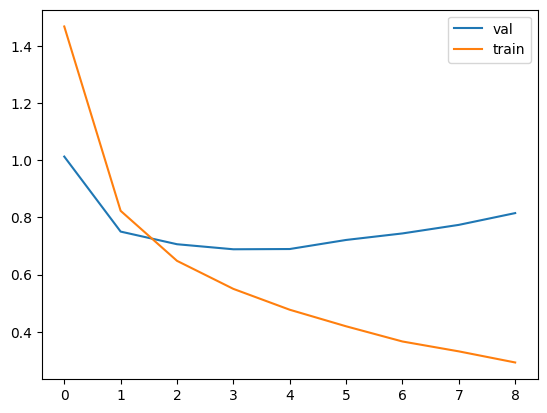

In [ ]:
plt.plot(history_crnn_s.history['val_loss'], label='val')
plt.plot(history_crnn_s.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_crnn_s.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 14s 43ms/step
              precision    recall  f1-score   support

           0       0.71      0.52      0.60      2503
           1       0.81      0.73      0.77      1632
           2       0.83      0.88      0.85      1652
           3       0.40      0.66      0.50      1161
           4       0.86      0.87      0.86      1607
           5       0.88      0.86      0.87      1481

    accuracy                           0.73     10036
   macro avg       0.75      0.75      0.74     10036
weighted avg       0.76      0.73      0.74     10036



In [ ]:
model_crnn_s.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 11)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 11, 100)           3635600   
                                                                 
 conv1d (Conv1D)             (None, 7, 64)             32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 64)             0         
 D)                                                              
                                                                 
 gru (GRU)                   (None, 100)               49800     
                                                                 
 dense_6 (Dense)             (None, 6)                

#### Model 4

NN model with CNN and GRU layers, Karina's implementation from lab2

In [ ]:
model_crnn_k = model_creator.create_model('crnn_k')

In [ ]:
with tf.device('/gpu:0'):
  history_crnn_k = model_crnn_k.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

Epoch 1/15
502/502 [==============================] - 45s 82ms/step - loss: 1.6354 - accuracy: 0.3411 - val_loss: 1.3020 - val_accuracy: 0.4834
Epoch 2/15
502/502 [==============================] - 23s 47ms/step - loss: 1.1639 - accuracy: 0.5191 - val_loss: 0.9902 - val_accuracy: 0.6528
Epoch 3/15
502/502 [==============================] - 32s 63ms/step - loss: 0.9118 - accuracy: 0.6427 - val_loss: 0.8414 - val_accuracy: 0.6777
Epoch 4/15
502/502 [==============================] - 26s 52ms/step - loss: 0.7712 - accuracy: 0.7012 - val_loss: 0.7820 - val_accuracy: 0.6983
Epoch 5/15
502/502 [==============================] - 24s 48ms/step - loss: 0.6870 - accuracy: 0.7332 - val_loss: 0.7691 - val_accuracy: 0.7038
Epoch 6/15
502/502 [==============================] - 26s 51ms/step - loss: 0.6290 - accuracy: 0.7584 - val_loss: 0.7567 - val_accuracy: 0.7049
Epoch 7/15
502/502 [==============================] - 25s 50ms/step - loss: 0.5808 - accuracy: 0.7810 - val_loss: 0.7662 - val_accuracy:

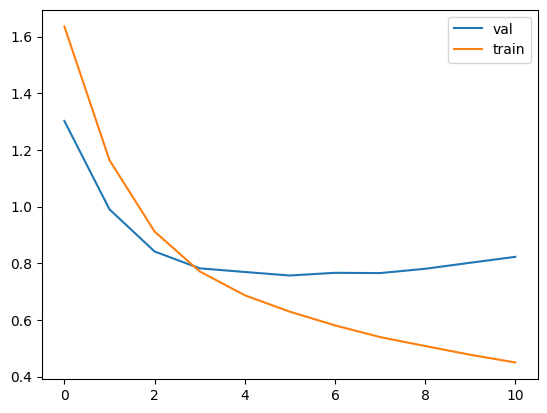

In [ ]:
plt.plot(history_crnn_k.history['val_loss'], label='val')
plt.plot(history_crnn_k.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_crnn_k.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 12s 35ms/step
              precision    recall  f1-score   support

           0       0.70      0.49      0.58      2503
           1       0.81      0.73      0.77      1632
           2       0.82      0.85      0.84      1652
           3       0.34      0.58      0.43      1161
           4       0.85      0.87      0.86      1607
           5       0.84      0.83      0.84      1481

    accuracy                           0.71     10036
   macro avg       0.73      0.73      0.72     10036
weighted avg       0.74      0.71      0.72     10036



In [ ]:
model_crnn_k.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (Text  (None, 11)                0         
 Vectorization)                                                  
                                                                 
 embedding_9 (Embedding)     (None, 11, 12)            436272    
                                                                 
 gru_4 (GRU)                 (None, 11, 32)            4416      
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 64)             6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 256)              

#### Model 5

CNN built not exactly as but similar to the model from https://thesai.org/Downloads/Volume14No10/Paper_45-Cyberbullying_Detection_using_Machine_Learning.pdf

In [ ]:
model_cnn_p = model_creator.create_model('cnn_p')

In [ ]:
with tf.device('/gpu:0'):
  history_cnn_p = model_cnn_p.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

Epoch 1/15
502/502 [==============================] - 34s 61ms/step - loss: 1.4548 - accuracy: 0.4122 - val_loss: 1.3092 - val_accuracy: 0.5755
Epoch 2/15
502/502 [==============================] - 22s 44ms/step - loss: 0.8347 - accuracy: 0.6868 - val_loss: 0.8466 - val_accuracy: 0.6702
Epoch 3/15
502/502 [==============================] - 28s 55ms/step - loss: 0.5717 - accuracy: 0.7925 - val_loss: 0.7604 - val_accuracy: 0.7025
Epoch 4/15
502/502 [==============================] - 22s 44ms/step - loss: 0.4229 - accuracy: 0.8536 - val_loss: 0.7328 - val_accuracy: 0.7155
Epoch 5/15
502/502 [==============================] - 22s 43ms/step - loss: 0.3172 - accuracy: 0.8950 - val_loss: 0.7275 - val_accuracy: 0.7214
Epoch 6/15
502/502 [==============================] - 23s 46ms/step - loss: 0.2402 - accuracy: 0.9238 - val_loss: 0.7362 - val_accuracy: 0.7307
Epoch 7/15
502/502 [==============================] - 25s 49ms/step - loss: 0.1820 - accuracy: 0.9444 - val_loss: 0.7581 - val_accuracy:

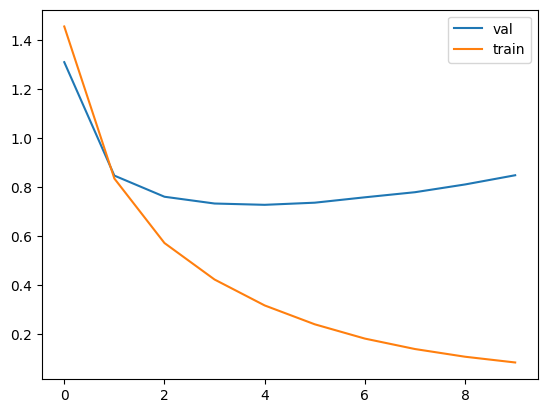

In [ ]:
plt.plot(history_cnn_p.history['val_loss'], label='val')
plt.plot(history_cnn_p.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_cnn_p.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 12s 37ms/step
              precision    recall  f1-score   support

           0       0.67      0.55      0.60      2503
           1       0.78      0.73      0.75      1632
           2       0.82      0.85      0.83      1652
           3       0.42      0.60      0.49      1161
           4       0.84      0.87      0.85      1607
           5       0.89      0.85      0.87      1481

    accuracy                           0.73     10036
   macro avg       0.74      0.74      0.73     10036
weighted avg       0.74      0.73      0.73     10036



In [ ]:
model_cnn_p.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (Text  (None, 11)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 11, 100)           3635600   
                                                                 
 batch_normalization (Batch  (None, 11, 100)           400       
 Normalization)                                                  
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 32)             9632      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 32)             0         
 g1D)                                                            
                                                      

#### Model 6

LLM-generated model

In [ ]:
model_n4 = model_creator.create_model('nnnn')

In [ ]:
with tf.device('/gpu:0'):
  history_n4 = model_n4.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

Epoch 1/15
502/502 [==============================] - 44s 85ms/step - loss: 1.6441 - accuracy: 0.3272 - val_loss: 1.4099 - val_accuracy: 0.4747
Epoch 2/15
502/502 [==============================] - 41s 83ms/step - loss: 1.1341 - accuracy: 0.6348 - val_loss: 0.9371 - val_accuracy: 0.7094
Epoch 3/15
502/502 [==============================] - 29s 57ms/step - loss: 0.7558 - accuracy: 0.7544 - val_loss: 0.7302 - val_accuracy: 0.7343
Epoch 4/15
502/502 [==============================] - 20s 39ms/step - loss: 0.5970 - accuracy: 0.7879 - val_loss: 0.6487 - val_accuracy: 0.7586
Epoch 5/15
502/502 [==============================] - 36s 71ms/step - loss: 0.5145 - accuracy: 0.8160 - val_loss: 0.6177 - val_accuracy: 0.7650
Epoch 6/15
502/502 [==============================] - 24s 48ms/step - loss: 0.4552 - accuracy: 0.8407 - val_loss: 0.5916 - val_accuracy: 0.7739
Epoch 7/15
502/502 [==============================] - 29s 58ms/step - loss: 0.4068 - accuracy: 0.8592 - val_loss: 0.5761 - val_accuracy:

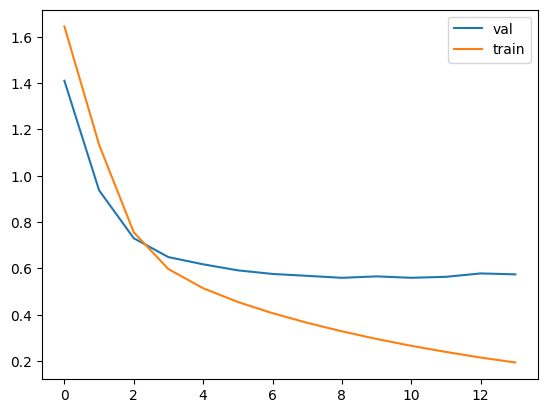

In [ ]:
plt.plot(history_n4.history['val_loss'], label='val')
plt.plot(history_n4.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_n4.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 12s 39ms/step
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      2503
           1       0.84      0.79      0.81      1632
           2       0.86      0.90      0.88      1652
           3       0.49      0.64      0.56      1161
           4       0.90      0.91      0.91      1607
           5       0.92      0.88      0.90      1481

    accuracy                           0.79     10036
   macro avg       0.79      0.79      0.79     10036
weighted avg       0.79      0.79      0.79     10036



In [ ]:
model_n4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (Text  (None, 11)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 11, 128)           4653568   
                                                                 
 flatten_3 (Flatten)         (None, 1408)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                22544     
                                                                 
 dense_11 (Dense)            (None, 6)                 102       
                                                                 
Total params: 4676214 (17.84 MB)
Trainable params: 4676214 (17.84 MB)
Non-trainable params: 0 (0.00 Byte)
______________

#### Выводы

Все модели показывают качество классификации в районе 70%–80%. Отметим, что это первый «общий» эксперимент, в котором мы попробовали оценить качество моделей на векторах размером со среднюю длину обработанных текстов в датасете. Мы расчитываем получить финальное качество предсказаний выше 80%, это лучший результат, который мы получили при работе с датасетом с применением моделей МО.

P.S. Из-за того, что метаэвристика сильно забивает ОЗУ, создавая множество моделей, мы пришли к решению сократить количество проверяемых моделей и взять только те, которые показали лучшие результаты на тестовом запуске (по стечению обстоятельств, ими оказались полносвязные модели)

### METAHEURISTIC FOR HYPERPARAMETERS TUNING

FEATURE 1 из статьи, выбранной Славой

Здесь используется библиотека Mealpy, содержащая большое количество метаэвристик, позволяющих находить оптимальные решения сложных задач. Мы опирались на статью (https://www.hindawi.com/journals/cin/2022/2163458/), в которой метаэвристики были применены для оптимизации фичей и подборки гиперпараметров модели. Также подбирая оптимальные гиперпараметры, такие как размеры векторов и словаря + осуществляя поиск наиболее подходящей архитектуры для классификации, используем ту же метаэвристику, что была применена в статье — Salp Swarm Optimizer.

Поскольку в статье не была приведена информация об имплементации метаэвристик, разборка с её применением происходила самостоятельно

In [ ]:
callback_problem = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
    )

#### Stage 1. Hyperparameters Optimization

В силу того, что обучение моделей занимает довольно много времени и на ЦПУ, и на ГПУ, а также забивает ОЗУ вплоть до вылета колаба, эвристику прогоняем на двух эпохах с небольшой популяцией (9)

In [ ]:
class NNOptProblem(Problem):
  def __init__(self, bounds=None, minmax='max', data=None, **kwargs):
    self.data = data
    super().__init__(bounds, minmax, **kwargs)

  def obj_func(self, x):
    x_decoded = self.decode_solution(x)
    print(x_decoded)
    vocab_sizes, vec_lens, model_names = x_decoded['vocab_sizes'], x_decoded['vec_lens'], x_decoded['model_names']
    vocab = create_vocab(token_counter, min_count=vocab_sizes)
    model_creator = StandardModel(vocab, int(vec_lens))
    model = model_creator.create_model(model_names)
    with tf.device('/gpu:0'):
      model.fit(self.data['x_train'], self.data['y_train'], epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_problem], class_weight=class_weights, verbose=0)
    y_pred = model.predict(self.data['x_test'])
    prediction = np.argmax(y_pred, axis=1)
    return f1_score(self.data['y_test'], prediction, average='macro')

In [ ]:
my_bounds = [
    IntegerVar(lb=0, ub=3, name='vocab_sizes'),
    IntegerVar(lb=5, ub=40, name='vec_lens'),
    StringVar(valid_sets=('full_con_s', 'full_con_k', 'crnn_s', 'crnn_k', 'cnn_p', 'nnnn'), name='model_names')
]
data = {
    'x_train': x_train,
    'x_test': x_test,
    'y_train': y_train,
    'y_test': y_test
}

problem = NNOptProblem(bounds=my_bounds, minmax="max", data=data)
model = OriginalSSO(epoch=2, pop_size=9)
model.solve(problem, seed=42)
print(f"Best agent: {model.g_best}")
print(f"Best solution: {model.g_best.solution}")
print(f"Best accuracy: {model.g_best.target.fitness}")
print(f"Best parameters: {model.problem.decode_solution(model.g_best.solution)}")

{'vocab_sizes': 2, 'vec_lens': 29, 'model_names': 'cnn_p'}
314/314 [==============================] - 7s 21ms/step


INFO:mealpy.swarm_based.SSO.OriginalSSO:Solving single objective optimization problem.


{'vocab_sizes': 0, 'vec_lens': 8, 'model_names': 'full_con_s'}
314/314 [==============================] - 16s 50ms/step
{'vocab_sizes': 3, 'vec_lens': 32, 'model_names': 'cnn_p'}
314/314 [==============================] - 5s 14ms/step
{'vocab_sizes': 2, 'vec_lens': 28, 'model_names': 'crnn_k'}
314/314 [==============================] - 7s 20ms/step
{'vocab_sizes': 1, 'vec_lens': 20, 'model_names': 'crnn_s'}
314/314 [==============================] - 10s 30ms/step
{'vocab_sizes': 1, 'vec_lens': 20, 'model_names': 'crnn_s'}
314/314 [==============================] - 8s 25ms/step
{'vocab_sizes': 3, 'vec_lens': 35, 'model_names': 'nnnn'}
314/314 [==============================] - 4s 14ms/step
{'vocab_sizes': 0, 'vec_lens': 8, 'model_names': 'full_con_s'}
314/314 [==============================] - 16s 49ms/step
{'vocab_sizes': 2, 'vec_lens': 30, 'model_names': 'cnn_p'}
314/314 [==============================] - 5s 17ms/step
{'vocab_sizes': 0, 'vec_lens': 12, 'model_names': 'full_con_k'}
314

INFO:mealpy.swarm_based.SSO.OriginalSSO:>>>Problem: P, Epoch: 1, Current best: 0.827488920479387, Global best: 0.827488920479387, Runtime: 1568.13063 seconds


{'vocab_sizes': 3, 'vec_lens': 34, 'model_names': 'nnnn'}
314/314 [==============================] - 4s 14ms/step
{'vocab_sizes': 3, 'vec_lens': 34, 'model_names': 'full_con_s'}
314/314 [==============================] - 6s 19ms/step
{'vocab_sizes': 3, 'vec_lens': 34, 'model_names': 'nnnn'}
314/314 [==============================] - 6s 19ms/step
{'vocab_sizes': 3, 'vec_lens': 34, 'model_names': 'full_con_s'}
314/314 [==============================] - 5s 15ms/step
{'vocab_sizes': 3, 'vec_lens': 34, 'model_names': 'nnnn'}
314/314 [==============================] - 5s 16ms/step
{'vocab_sizes': 2, 'vec_lens': 29, 'model_names': 'full_con_k'}
314/314 [==============================] - 6s 18ms/step
{'vocab_sizes': 1, 'vec_lens': 20, 'model_names': 'full_con_k'}
314/314 [==============================] - 9s 27ms/step
{'vocab_sizes': 1, 'vec_lens': 18, 'model_names': 'crnn_s'}
314/314 [==============================] - 9s 29ms/step
{'vocab_sizes': 2, 'vec_lens': 23, 'model_names': 'crnn_k'}
31

INFO:mealpy.swarm_based.SSO.OriginalSSO:>>>Problem: P, Epoch: 2, Current best: 0.8311626310972811, Global best: 0.8311626310972811, Runtime: 1140.35010 seconds


Best agent: id: 55, target: Objectives: [0.83116263], Fitness: 0.8311626310972811, solution: [ 3.07602389 33.75017247  5.        ]
Best solution: [ 3.07602389 33.75017247  5.        ]
Best accuracy: 0.8311626310972811
Best parameters: {'vocab_sizes': 3, 'vec_lens': 34, 'model_names': 'nnnn'}


#### Stage 2. Choosing Best Models

In [ ]:
callback_search = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
    )

In [ ]:
vocab = create_vocab(token_counter, 3)
len(vocab)

9535

In [ ]:
with open('vocab.pkl', 'wb') as file:
  pickle.dump(vocab, file)

In [ ]:
new_model_creator = StandardModel(vocab, 34)

##### Best Model

In [ ]:
best_model = new_model_creator.create_model('nnnn')

In [ ]:
with tf.device('/gpu:0'):
  history_best = best_model.fit(x_train, y_train, epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_search], class_weight=class_weights)

Epoch 1/32
251/251 [==============================] - 11s 41ms/step - loss: 1.6695 - accuracy: 0.2597 - val_loss: 1.5097 - val_accuracy: 0.3806
Epoch 2/32
251/251 [==============================] - 11s 44ms/step - loss: 1.2370 - accuracy: 0.5467 - val_loss: 1.0286 - val_accuracy: 0.6661
Epoch 3/32
251/251 [==============================] - 13s 51ms/step - loss: 0.8566 - accuracy: 0.7086 - val_loss: 0.7783 - val_accuracy: 0.7321
Epoch 4/32
251/251 [==============================] - 10s 42ms/step - loss: 0.6652 - accuracy: 0.7628 - val_loss: 0.6745 - val_accuracy: 0.7333
Epoch 5/32
251/251 [==============================] - 12s 46ms/step - loss: 0.5628 - accuracy: 0.7900 - val_loss: 0.5920 - val_accuracy: 0.7741
Epoch 6/32
251/251 [==============================] - 10s 40ms/step - loss: 0.5003 - accuracy: 0.8071 - val_loss: 0.5487 - val_accuracy: 0.7880
Epoch 7/32
251/251 [==============================] - 21s 85ms/step - loss: 0.4571 - accuracy: 0.8235 - val_loss: 0.5235 - val_accuracy:

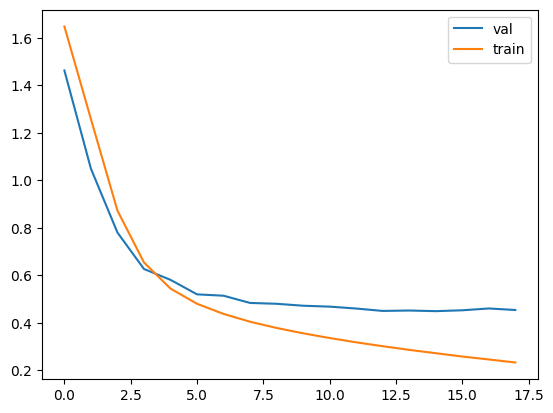

In [ ]:
plt.plot(history_best.history['val_loss'], label='val')
plt.plot(history_best.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = best_model.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 6s 20ms/step
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      2503
           1       0.88      0.82      0.85      1632
           2       0.92      0.93      0.92      1652
           3       0.52      0.65      0.58      1161
           4       0.96      0.98      0.97      1607
           5       0.97      0.92      0.94      1481

    accuracy                           0.82     10036
   macro avg       0.83      0.83      0.83     10036
weighted avg       0.83      0.82      0.82     10036



In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 34)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 34, 128)           1220736   
                                                                 
 flatten (Flatten)           (None, 4352)              0         
                                                                 
 dense (Dense)               (None, 16)                69648     
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 1290486 (4.92 MB)
Trainable params: 1290486 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
best_model.save_weights('drive/MyDrive/data/cyberbullying/full_con_nn_weights.h5')

In [ ]:
best_model.save('drive/MyDrive/data/cyberbullying/full_con_nn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Model Type 1

In [ ]:
model_type1 = new_model_creator.create_model('full_con_s')

In [ ]:
with tf.device('/gpu:0'):
  history_type1 = model_type1.fit(x_train, y_train, epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_search], class_weight=class_weights)

Epoch 1/32
251/251 [==============================] - 22s 81ms/step - loss: 1.7074 - accuracy: 0.2436 - val_loss: 1.5898 - val_accuracy: 0.4034
Epoch 2/32
251/251 [==============================] - 22s 86ms/step - loss: 1.3987 - accuracy: 0.4460 - val_loss: 1.0908 - val_accuracy: 0.6176
Epoch 3/32
251/251 [==============================] - 13s 53ms/step - loss: 1.0178 - accuracy: 0.5981 - val_loss: 0.7766 - val_accuracy: 0.7411
Epoch 4/32
251/251 [==============================] - 22s 87ms/step - loss: 0.8008 - accuracy: 0.6798 - val_loss: 0.6418 - val_accuracy: 0.7662
Epoch 5/32
251/251 [==============================] - 19s 75ms/step - loss: 0.6821 - accuracy: 0.7231 - val_loss: 0.5881 - val_accuracy: 0.7771
Epoch 6/32
251/251 [==============================] - 12s 50ms/step - loss: 0.6140 - accuracy: 0.7475 - val_loss: 0.5545 - val_accuracy: 0.7818
Epoch 7/32
251/251 [==============================] - 12s 48ms/step - loss: 0.5723 - accuracy: 0.7707 - val_loss: 0.5346 - val_accuracy:

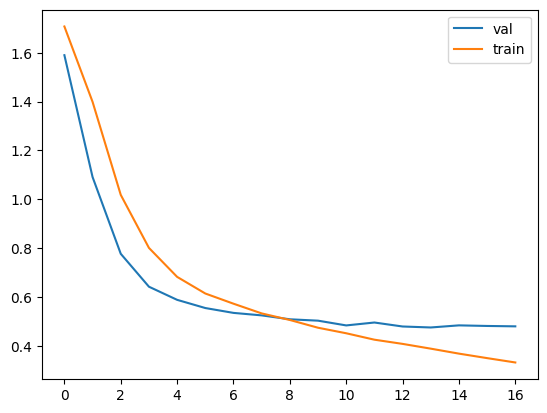

In [ ]:
plt.plot(history_type1.history['val_loss'], label='val')
plt.plot(history_type1.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_type1.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 6s 20ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      2503
           1       0.87      0.83      0.85      1632
           2       0.91      0.94      0.93      1652
           3       0.53      0.60      0.56      1161
           4       0.96      0.98      0.97      1607
           5       0.97      0.93      0.95      1481

    accuracy                           0.82     10036
   macro avg       0.82      0.82      0.82     10036
weighted avg       0.82      0.82      0.82     10036



In [ ]:
model_type1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 34)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 34, 128)           1220736   
                                                                 
 flatten_1 (Flatten)         (None, 4352)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                278592    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                      

In [ ]:
model_type1.save_weights('drive/MyDrive/data/cyberbullying/full_con_weights.keras')

In [ ]:
model_type1.save('drive/MyDrive/data/cyberbullying/full_con.h5')

##### Model Type 2

In [ ]:
model_type2 = new_model_creator.create_model('full_con_k')

In [ ]:
with tf.device('/gpu:0'):
  history_type2 = model_type2.fit(x_train, y_train, epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_search], class_weight=class_weights)

Epoch 1/32
251/251 [==============================] - 7s 25ms/step - loss: 1.7524 - accuracy: 0.2980 - val_loss: 1.6727 - val_accuracy: 0.3479
Epoch 2/32
251/251 [==============================] - 7s 29ms/step - loss: 1.5875 - accuracy: 0.3529 - val_loss: 1.4525 - val_accuracy: 0.4134
Epoch 3/32
251/251 [==============================] - 6s 25ms/step - loss: 1.3599 - accuracy: 0.4618 - val_loss: 1.2186 - val_accuracy: 0.5686
Epoch 4/32
251/251 [==============================] - 8s 30ms/step - loss: 1.1834 - accuracy: 0.5224 - val_loss: 1.0525 - val_accuracy: 0.6112
Epoch 5/32
251/251 [==============================] - 6s 24ms/step - loss: 1.0721 - accuracy: 0.5452 - val_loss: 0.9500 - val_accuracy: 0.6229
Epoch 6/32
251/251 [==============================] - 8s 30ms/step - loss: 1.0034 - accuracy: 0.5666 - val_loss: 0.8940 - val_accuracy: 0.6245
Epoch 7/32
251/251 [==============================] - 7s 27ms/step - loss: 0.9447 - accuracy: 0.5875 - val_loss: 0.8402 - val_accuracy: 0.6351

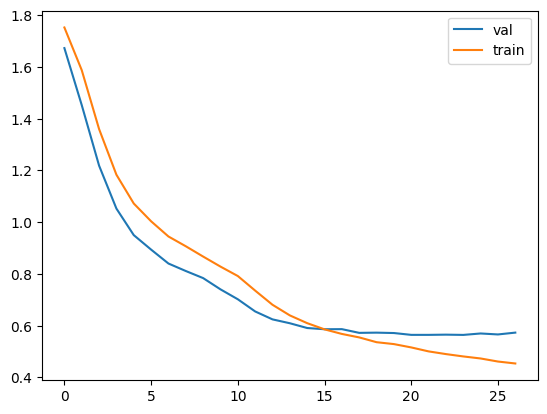

In [ ]:
plt.plot(history_type2.history['val_loss'], label='val')
plt.plot(history_type2.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_type2.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 8s 25ms/step
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      2503
           1       0.88      0.80      0.84      1632
           2       0.89      0.93      0.91      1652
           3       0.46      0.60      0.52      1161
           4       0.96      0.97      0.96      1607
           5       0.94      0.91      0.93      1481

    accuracy                           0.80     10036
   macro avg       0.81      0.81      0.80     10036
weighted avg       0.81      0.80      0.80     10036



In [ ]:
model_type2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_29 (Tex  (None, 34)                0         
 tVectorization)                                                 
                                                                 
 embedding_29 (Embedding)    (None, 34, 40)            381480    
                                                                 
 flatten_24 (Flatten)        (None, 1360)              0         
                                                                 
 dense_66 (Dense)            (None, 20)                27220     
                                                                 
 dense_67 (Dense)            (None, 10)                210       
                                                                 
 dropout_25 (Dropout)        (None, 10)                0         
                                                     

##### Model Type 3

In [ ]:
model_type3 = new_model_creator.create_model('crnn_s')

In [ ]:
with tf.device('/gpu:0'):
  history_type3 = model_type3.fit(x_train, y_train, epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_search], class_weight=class_weights)

Epoch 1/32
251/251 [==============================] - 48s 180ms/step - loss: 1.6517 - accuracy: 0.2511 - val_loss: 1.3031 - val_accuracy: 0.4504
Epoch 2/32
251/251 [==============================] - 44s 175ms/step - loss: 1.1573 - accuracy: 0.5082 - val_loss: 1.1003 - val_accuracy: 0.5586
Epoch 3/32
251/251 [==============================] - 32s 128ms/step - loss: 0.9936 - accuracy: 0.5686 - val_loss: 1.0116 - val_accuracy: 0.5595
Epoch 4/32
251/251 [==============================] - 27s 106ms/step - loss: 0.8670 - accuracy: 0.6197 - val_loss: 0.9265 - val_accuracy: 0.6180
Epoch 5/32
251/251 [==============================] - 25s 98ms/step - loss: 0.7611 - accuracy: 0.6747 - val_loss: 0.8536 - val_accuracy: 0.6637
Epoch 6/32
251/251 [==============================] - 24s 94ms/step - loss: 0.6742 - accuracy: 0.7280 - val_loss: 0.8054 - val_accuracy: 0.6991
Epoch 7/32
251/251 [==============================] - 26s 105ms/step - loss: 0.6139 - accuracy: 0.7654 - val_loss: 0.7699 - val_accu

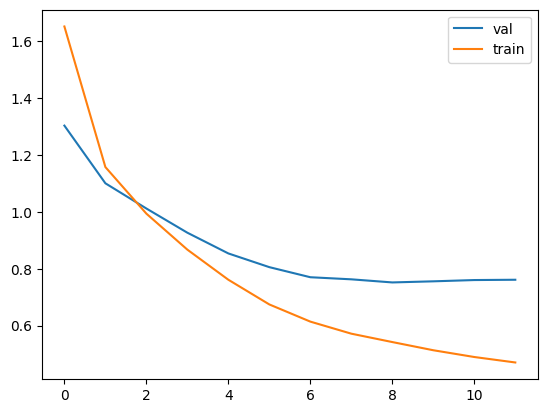

In [ ]:
plt.plot(history_type3.history['val_loss'], label='val')
plt.plot(history_type3.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_type3.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 9s 26ms/step
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      2503
           1       0.84      0.74      0.79      1632
           2       0.87      0.89      0.88      1652
           3       0.40      0.55      0.46      1161
           4       0.91      0.98      0.94      1607
           5       0.80      0.81      0.80      1481

    accuracy                           0.74     10036
   macro avg       0.74      0.75      0.74     10036
weighted avg       0.75      0.74      0.74     10036



In [ ]:
model_type3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_30 (Tex  (None, 34)                0         
 tVectorization)                                                 
                                                                 
 embedding_30 (Embedding)    (None, 34, 100)           953700    
                                                                 
 conv1d_11 (Conv1D)          (None, 30, 64)            32064     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 15, 64)            0         
 ng1D)                                                           
                                                                 
 gru_8 (GRU)                 (None, 100)               49800     
                                                                 
 dense_69 (Dense)            (None, 6)               

##### Model Type 4

In [ ]:
model_type4 = new_model_creator.create_model('crnn_k')

In [ ]:
with tf.device('/gpu:0'):
  history_type4 = model_type4.fit(x_train, y_train, epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_search], class_weight=class_weights)

Epoch 1/32
251/251 [==============================] - 27s 96ms/step - loss: 1.7481 - accuracy: 0.2654 - val_loss: 1.6408 - val_accuracy: 0.2691
Epoch 2/32
251/251 [==============================] - 12s 49ms/step - loss: 1.4964 - accuracy: 0.3663 - val_loss: 1.2418 - val_accuracy: 0.5422
Epoch 3/32
251/251 [==============================] - 15s 61ms/step - loss: 1.0943 - accuracy: 0.5542 - val_loss: 0.8914 - val_accuracy: 0.6528
Epoch 4/32
251/251 [==============================] - 15s 58ms/step - loss: 0.8370 - accuracy: 0.6584 - val_loss: 0.7614 - val_accuracy: 0.7213
Epoch 5/32
251/251 [==============================] - 12s 48ms/step - loss: 0.7432 - accuracy: 0.6985 - val_loss: 0.7239 - val_accuracy: 0.7280
Epoch 6/32
251/251 [==============================] - 12s 49ms/step - loss: 0.6888 - accuracy: 0.7176 - val_loss: 0.7057 - val_accuracy: 0.7290
Epoch 7/32
251/251 [==============================] - 13s 52ms/step - loss: 0.6502 - accuracy: 0.7332 - val_loss: 0.6992 - val_accuracy:

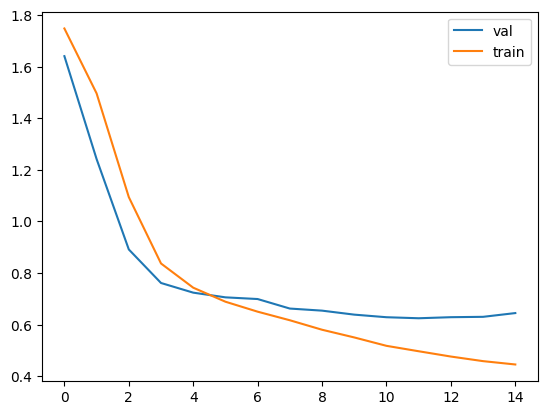

In [ ]:
plt.plot(history_type4.history['val_loss'], label='val')
plt.plot(history_type4.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_type4.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 7s 21ms/step
              precision    recall  f1-score   support

           0       0.69      0.48      0.57      2503
           1       0.78      0.77      0.77      1632
           2       0.90      0.91      0.90      1652
           3       0.38      0.63      0.47      1161
           4       0.94      0.94      0.94      1607
           5       0.93      0.90      0.92      1481

    accuracy                           0.75     10036
   macro avg       0.77      0.77      0.76     10036
weighted avg       0.78      0.75      0.76     10036



In [ ]:
model_type4.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_31 (Tex  (None, 34)                0         
 tVectorization)                                                 
                                                                 
 embedding_31 (Embedding)    (None, 34, 12)            114444    
                                                                 
 gru_9 (GRU)                 (None, 34, 32)            4416      
                                                                 
 conv1d_12 (Conv1D)          (None, 32, 16)            1552      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 16, 16)            0         
 ng1D)                                                           
                                                                 
 flatten_25 (Flatten)        (None, 256)             

##### Model Type 5

In [ ]:
model_type5 = new_model_creator.create_model('cnn_p')

In [ ]:
with tf.device('/gpu:0'):
  history_type5 = model_type5.fit(x_train, y_train, epochs=32, batch_size=128, validation_split=0.2, callbacks=[callback_search], class_weight=class_weights)

Epoch 1/32
251/251 [==============================] - 15s 53ms/step - loss: 1.6194 - accuracy: 0.3295 - val_loss: 1.6948 - val_accuracy: 0.4877
Epoch 2/32
251/251 [==============================] - 13s 53ms/step - loss: 1.0998 - accuracy: 0.5970 - val_loss: 1.2123 - val_accuracy: 0.6599
Epoch 3/32
251/251 [==============================] - 14s 54ms/step - loss: 0.7927 - accuracy: 0.7321 - val_loss: 0.8096 - val_accuracy: 0.7407
Epoch 4/32
251/251 [==============================] - 13s 52ms/step - loss: 0.5718 - accuracy: 0.8214 - val_loss: 0.6273 - val_accuracy: 0.7650
Epoch 5/32
251/251 [==============================] - 13s 52ms/step - loss: 0.4376 - accuracy: 0.8501 - val_loss: 0.5743 - val_accuracy: 0.7751
Epoch 6/32
251/251 [==============================] - 13s 53ms/step - loss: 0.3628 - accuracy: 0.8755 - val_loss: 0.5548 - val_accuracy: 0.7818
Epoch 7/32
251/251 [==============================] - 13s 52ms/step - loss: 0.3080 - accuracy: 0.8955 - val_loss: 0.5494 - val_accuracy:

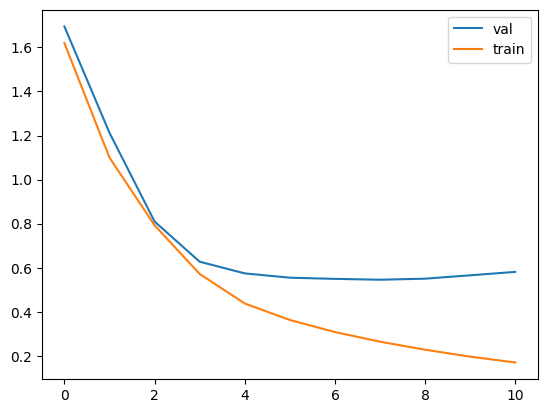

In [ ]:
plt.plot(history_type5.history['val_loss'], label='val')
plt.plot(history_type5.history['loss'], label='train')
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred = model_type5.predict(x_test)
prediction = np.argmax(pred, axis=1)
print(classification_report(y_test, prediction))

314/314 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

           0       0.70      0.62      0.65      2503
           1       0.89      0.77      0.83      1632
           2       0.93      0.90      0.91      1652
           3       0.44      0.68      0.54      1161
           4       0.96      0.96      0.96      1607
           5       0.97      0.91      0.94      1481

    accuracy                           0.79     10036
   macro avg       0.81      0.81      0.80     10036
weighted avg       0.82      0.79      0.80     10036



In [ ]:
model_type5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 34)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 34, 100)           953700    
                                                                 
 batch_normalization (Batch  (None, 34, 100)           400       
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                      

In [ ]:
model_type5.save_weights('drive/MyDrive/data/cyberbullying/cnn_p_weights.keras')

In [ ]:
model_type5.save('drive/MyDrive/data/cyberbullying/cnn_p.h5')

##### Вывод

Качество в среднем стало незначительно лучше. Сохраняем 3 модели, показавшие результат выше 80%

### Symbiotic model

FEATURE 2 из статьи, выбранной Кариной

In [ ]:
class SymbioticNN:
  def __init__(self, vocab, model1: str | Sequential, model2: str | Sequential, m1w: float = 0.5):
    for model in (model1, model2):
      if not isinstance(model, str) and not isinstance(model, Sequential):
        raise TypeError(f'{model} has inappropriate class {type(model)}. Valid classes are (str | keras.Sequential)')
    self._vocab = vocab
    self._vec_len = 34
    self._balance = m1w
    self._model_builder = StandardModel(self._vocab, self._vec_len)
    if isinstance(model1, str):
      self._model1 = self._model_builder.create_model(model1)
    elif isinstance(model1, Sequential):
      self._model1 = model1
    if isinstance(model2, str):
      self._model2 = self._model_builder.create_model(model2)
    elif isinstance(model2, Sequential):
      self._model2 = model2
    self._classes_mapping = {0: 'not_cyberbullying',
                             1: 'gender',
                             2: 'religion',
                             3: 'other_cyberbullying',
                             4: 'age',
                             5: 'ethnicity'}

  def fit_models(self):
    with tf.device('/gpu:0'):
      self._model1.fit(x_train, y_train, epochs=64, batch_size=128, validation_split=0.2, callbacks=[callback], class_weight=class_weights)
      self._model2.fit(x_train, y_train, epochs=64, batch_size=128, validation_split=0.2, callbacks=[callback], class_weight=class_weights)

    self.evaluate()

  def evaluate(self):
    pred1 = self._model1.predict(x_test)
    pred2 = self._model2.predict(x_test)
    pred = np.log(pred1 * self._balance + pred2 * (1 - self._balance))
    prediction = np.argmax(pred, axis=1)
    print(classification_report(y_test, prediction))

  def infer(self, preprocessed_text: str):
    pred1 = self._model1(preprocessed_text, training=False)
    pred2 = self._model2(preprocessed_text, training=False)
    pred = np.log(pred1 * self._balance + pred2 * (1 - self._balance))
    prediction = np.argmax(pred, axis=1)

    return self._classes_mapping.get(*prediction)

#### Best + Full_conn_s

In [ ]:
symbiont = SymbioticNN(vocab, best_model, model_type1, 0.5)
# symbiont.fit_models()
symbiont.evaluate()

314/314 [==============================] - 6s 20ms/step
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      2503
           1       0.88      0.83      0.85      1632
           2       0.92      0.94      0.93      1652
           3       0.51      0.71      0.60      1161
           4       0.96      0.98      0.97      1607
           5       0.96      0.93      0.95      1481

    accuracy                           0.83     10036
   macro avg       0.83      0.84      0.83     10036
weighted avg       0.84      0.83      0.83     10036



Посмотрим, что у нас по предсказаниям

In [ ]:
# No cyberbullying

infer_text = """Conversations
With simulations
They say there's no escaping
It's a never-ending road"""

symbiont.infer(pd.Series([preprocess(infer_text)]))

'not_cyberbullying'

In [ ]:
infer_text = """Conversations
With simulations
They say there's no escaping
It's a never-ending road"""

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'not_cyberbullying'

Кибербуллинга в предложении нет, всё правильно

In [ ]:
# Cyberbullying

infer_text = "Are you kidding me? All blacks are potential killers!"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'ethnicity'

In [ ]:
infer_text = "Are you kidding me? All blacks are potential killers!"

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'ethnicity'

Кибербуллинг в предложении есть, всё правильно

In [ ]:
# Cyberbullying*

infer_text = "All Jews should be deported from Europe"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'not_cyberbullying'

In [ ]:
infer_text = "All Jews should be deported from Europe"

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'not_cyberbullying'

Кибербуллинг присутствует, но моделька не поняла. Может быть, слово *евреи* в кибербуллинге не так часто встречалось или же контекст о депортации был положительным

Далее идут более сложные примеры

In [ ]:
# No cyberbullying*

infer_text = "Muslims are actually good guys"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'religion'

In [ ]:
infer_text = "Muslims are actually good guys"

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'religion'

Вероятно, слово *мусульмане* очень сильно влияют на предсказание модели. Также мы в датасете удаляем стоп-слова, в которые чисто теоретически может войти и *good*, из-за чего предсказание становится ложноположительным

#### Full_conn_s + CNN_P

In [ ]:
symbiont = SymbioticNN(vocab, model_type1, model_type5, 0.6)
# symbiont.fit_models()
symbiont.evaluate()

314/314 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

           0       0.76      0.61      0.68      2503
           1       0.87      0.83      0.85      1632
           2       0.91      0.94      0.93      1652
           3       0.50      0.73      0.60      1161
           4       0.96      0.98      0.97      1607
           5       0.96      0.93      0.95      1481

    accuracy                           0.82     10036
   macro avg       0.83      0.84      0.83     10036
weighted avg       0.83      0.82      0.82     10036



In [ ]:
# No cyberbullying

infer_text = """Conversations
With simulations
They say there's no escaping
It's a never-ending road"""

symbiont.infer(pd.Series([preprocess(infer_text)]))

'not_cyberbullying'

In [ ]:
# Cyberbullying

infer_text = "Are you kidding me? All blacks are potential killers!"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'ethnicity'

In [ ]:
# Cyberbullying*

infer_text = "All Jews should be deported from Europe"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'religion'

Вот тут интересно. Видимо, одна из моделей выдаёт большую вероятность этому классу и мы получаем ожидаемое предсказание.

In [ ]:
# No cyberbullying*

infer_text = "Muslims are actually good guys"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'religion'

#### Best + CNN_P

In [ ]:
symbiont = SymbioticNN(vocab, best_model, model_type5, 0.6)
# symbiont.fit_models()
symbiont.evaluate()

314/314 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2503
           1       0.88      0.82      0.85      1632
           2       0.92      0.93      0.92      1652
           3       0.51      0.64      0.57      1161
           4       0.97      0.98      0.97      1607
           5       0.97      0.92      0.94      1481

    accuracy                           0.82     10036
   macro avg       0.83      0.83      0.83     10036
weighted avg       0.83      0.82      0.83     10036



In [ ]:
# No cyberbullying

infer_text = """Conversations
With simulations
They say there's no escaping
It's a never-ending road"""

symbiont.infer(pd.Series([preprocess(infer_text)]))

'not_cyberbullying'

In [ ]:
infer_text = """Conversations
With simulations
They say there's no escaping
It's a never-ending road"""

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'not_cyberbullying'

In [ ]:
# Cyberbullying

infer_text = "Are you kidding me? All blacks are potential killers!"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'other_cyberbullying'

In [ ]:
infer_text = "Are you kidding me? All blacks are potential killers!"

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'ethnicity'

Кибербуллинг определён, но почему-то моднль предсказала, что это не по этничности

In [ ]:
# Cyberbullying*

infer_text = "All Jews should be deported from Europe"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'not_cyberbullying'

In [ ]:
infer_text = "All Jews should be deported from Europe"

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'not_cyberbullying'

In [ ]:
# No cyberbullying*

infer_text = "Muslims are actually good guys"
symbiont.infer(pd.Series([preprocess(infer_text)]))

'religion'

In [ ]:
infer_text = "Muslims are actually good guys"

labels_map.get(np.argmax(best_model(pd.Series([preprocess(infer_text)]))))

'religion'

Уже в третий раз неверное

#### Conclusions

Есть ощущение, что некоторые слова-триггеры играют большую роль в определении класса, из-за чего при изменении контекста употребления таких слов модель всё равно предсказывает тот класс, в котором они чаще всего встречались в датасете.

Видимо, на предсказание влияет и то, что мы удаляем стоп-слова, что может мешать модели определить контекст

## Overall Conclusion

Модели собраны, две фичи реализованы, качество не самое плохое. Тем не менее эти результаты лишь незначительно лучше, чем результаты, полученные нами ранее с применением классических методов машинного обучения (SVC, LogReg)

Стоит добавить, что эта лабораторная очень красиво зацикливает наше изучение МО. Год назад мы работали над задачей детекции кб с помощью «обычного» машинного обучения, и вот, спустя столько времени, посмотрели на результаты в разрезе нового подхода
.
.
.
нейронных сетей!!!!!!!!!!!!!!!!!!!

P.S.

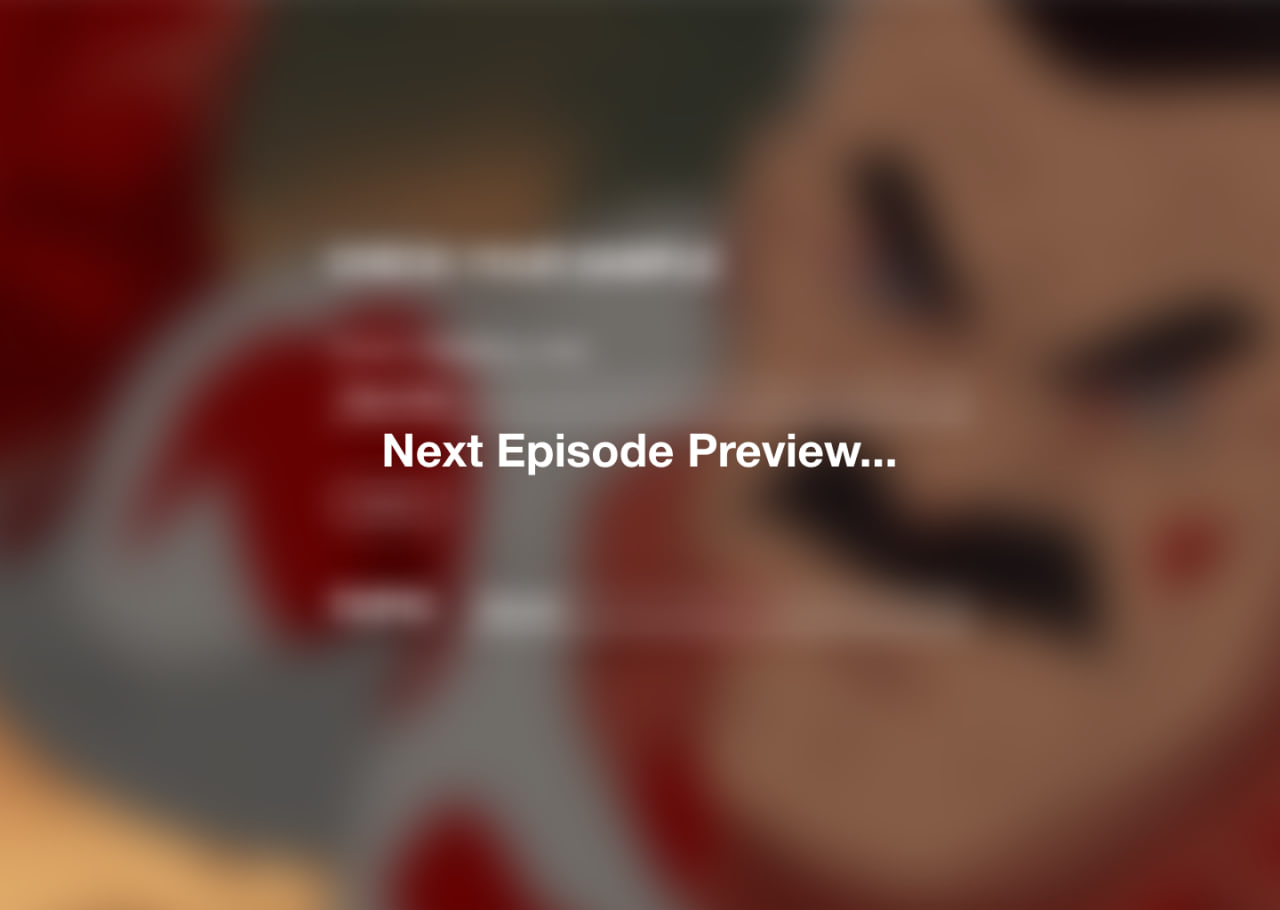